# Packages 

* PIL for images
* torchvision for pytorch computer vision support 
* datasets -> loading dataset with huggingface dataset api
* matplotlib for showing images
* torch and its many packages and modules for nn
* tqdm for progress bar when training and testing
* numpy for math stuff
* ray tune for hyperparameter otpimization
* torch summary for model params count
* typing for better clarity 

In [1]:
# install packages
!pip -q install accelerate datasets evaluate torchvision Pillow 'transformers[torch]' tqdm ray tensorboardX torchmetrics torchsummary scikit-learn numpy torch matplotlib pandas

You should consider upgrading via the '/Users/kelley/Desktop/drawAI/.env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Subset
import random
from ray import tune
from tensorboardX import SummaryWriter
from ray.tune.stopper import MaximumIterationStopper, TrialPlateauStopper
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import AveragePrecision
from sklearn.metrics import f1_score, precision_score, recall_score
from torchsummary import summary
from datasets import Dataset, DatasetDict
from typing import List, Dict, Any
import pandas as pd

/Users/kelley/Desktop/drawAI/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kelley/Desktop/drawAI/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-26 21:31:54,608	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-26 21:31:54,665	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Dataset infromation 
* 10% Subset of Google's 50 million quickdraw dataset 
    * training -> 4.5 million
    * validation -> .5 million 
    * test ->.5 million
* link -> https://huggingface.co/datasets/Xenova/quickdraw-small?row=0
* 28 x 28 images of drawings 
* 345 labels 


In [3]:
# mac gpu loading 
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# loading dataset into huggign face dataset dictionary/object
dataset:DatasetDict = load_dataset('Xenova/quickdraw-small')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4500000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
})


In [4]:
# 3 batches tested for each, previously generated with random
# example
# batcha_selected_classes_10  = random.sample(range(0, 344), 10)
batcha_selected_classes_10 = [121, 162, 120, 211, 43, 185, 177, 171, 232, 322]
batcha_selected_classes_50 = [143, 149, 306, 233, 107, 196, 129, 186, 22, 227, 16, 253, 199, 194, 333, 122, 297, 307, 217, 42, 251, 158, 324, 124, 334, 270, 165, 78, 214, 289, 69, 169, 206, 133, 278, 262, 298, 54, 115, 272, 110, 215, 209, 172, 328, 5, 207, 14, 9, 51]
batchb_selected_classes_10 = [223, 60, 237, 51, 234, 94, 53, 161, 300, 320]
batchb_selected_classes_50 = [148, 30, 79, 253, 18, 6, 141, 116, 150, 273, 68, 339, 262, 302, 197, 56, 333, 182, 265, 323, 101, 226, 308, 155, 171, 199, 25, 28, 48, 10, 342, 66, 104, 318, 185, 330, 263, 257, 35, 296, 70, 228, 272, 316, 42, 69, 233, 127, 217, 169]
batchc_selected_classes_10 = [302, 323, 107, 312, 184, 235, 179, 146, 38, 149]
batchc_selected_classes_50 = [248, 32, 60, 128, 290, 77, 49, 282, 95, 176, 193, 72, 189, 226, 100, 107, 304, 308, 14, 287, 35, 250, 111, 297, 291, 112, 62, 168, 136, 11, 323, 327, 239, 88, 159, 120, 257, 240, 24, 16, 148, 160, 40, 96, 155, 53, 280, 36, 64, 151]

# pytorch must have labels 0 - x, so using dict to create mapping
# i.e 121::0, 162:1, using this mapping later
def create_label_mapping(selected_classes: List[int]) -> Dict[int, int]:
    return {old_label: new_label for new_label, old_label in enumerate(selected_classes)}

# function to create a flag in the dataset to filter based on
# there are better ways to do this but trying to use pretrained models later
# and want it as flexible as possible
def transform_example(example: Dict[str, Any], selected_classes: List[int], label_mapping: Dict[int, int]) -> Dict[str, Any]:
    if example['label'] in selected_classes:
        return {'image': example['image'], 'label': label_mapping[example['label']], 'is_selected': True}
    else:
        return {'is_selected': False}


# dictorying storing each diction
datasets: Dict[str, DatasetDict[str, Dataset]] = {}

# applying everything to all 6 batches 
for batch, selected_classes in [('batcha', batcha_selected_classes_10),
                                ('batcha', batcha_selected_classes_50),
                                ('batchb', batchb_selected_classes_10),
                                ('batchb', batchb_selected_classes_50),
                                ('batchc', batchc_selected_classes_10),
                                ('batchc', batchc_selected_classes_50)]:
    # getting the label mapping
    label_mapping:Dict[int, int] = create_label_mapping(selected_classes)
    # flagging and mapping labels each class
    dataset_with_updated_labels: DatasetDict = dataset.map(lambda x: transform_example(x, selected_classes, label_mapping))
    
    # filtering classes that are flagged/selected
    # very pythonic syntax cuz train, val, test splits 
    filtered_dataset: Dict[str, Dataset] = {split: ds.filter(lambda x: x['is_selected']) for split, ds in dataset_with_updated_labels.items()}
    datasets[f"{batch}_{len(selected_classes)}"] = filtered_dataset


# Data Pipeline 

- transforing dataset to tensors
- storing everything in a dict 
- subsetting data based on batches 

In [5]:
def transform(dataset: DatasetDict) -> Dict[str, torch.Tensor]:
    # pytorch preprocess
    processor: transforms.Compose = transforms.Compose([
        # augment stuff for later to see if it improves performance
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),  # range of values 0 - 1
        transforms.Normalize((0.5,), (0.5,)),  # std .5, mean .5
    ])
    # convert each image to 3d numpy array then reshape into a (height, width)) tensor
    images: List[torch.Tensor] = [processor(np.array(x).reshape(28, 28)) for x in dataset['image']]
    # return dictionary containing single 3d tensor storing all images and 1d tensor for labels
    return {'image': torch.stack(images), 'label': torch.tensor(dataset['label'])}

## Subsetting data 
Original Data 4.5 Million rows 90/5/5 split
Updated 

- 10 Classes: 100% Train. 100% Validation% 100% Testing

- 50 Classes: 30% Train.  60% Validation% 60% Testing

- 345 Classes: 25% Train. 50% Validation% 50% Testing

- Using pytorch subset to do this!


In [6]:
# BatchA 10 classes
transformed_dataset_batcha_10 = {split: ds.with_transform(transform) for split, ds in datasets['batcha_10'].items()}

subset_ratio = 1
train_subset_size_batcha_10 = int(subset_ratio * len(transformed_dataset_batcha_10['train']))
subset_train_dataset_batcha_10 = Subset(transformed_dataset_batcha_10['train'], range(train_subset_size_batcha_10))

subset_ratio = 1
val_subset_size_batcha_10 = int(subset_ratio * len(transformed_dataset_batcha_10['valid']))
subset_validation_dataset_batcha_10 = Subset(transformed_dataset_batcha_10['valid'], range(val_subset_size_batcha_10))

subset_ratio = 1
test_subset_size_batcha_10 = int(subset_ratio * len(transformed_dataset_batcha_10['test']))
subset_test_dataset_batcha_10 = Subset(transformed_dataset_batcha_10['test'], range(test_subset_size_batcha_10))

train_loader_batcha_10 = DataLoader(subset_train_dataset_batcha_10, batch_size=16, shuffle=True)
validation_loader_batcha_10 = DataLoader(subset_validation_dataset_batcha_10, batch_size=16, shuffle=False)
test_loader_batcha_10 = DataLoader(subset_test_dataset_batcha_10, batch_size=16, shuffle=False)

# BatchB 10 classes
transformed_dataset_batchb_10 = {split: ds.with_transform(transform) for split, ds in datasets['batchb_10'].items()}

subset_ratio = 1
train_subset_size_batchb_10 = int(subset_ratio * len(transformed_dataset_batchb_10['train']))
subset_train_dataset_batchb_10 = Subset(transformed_dataset_batchb_10['train'], range(train_subset_size_batchb_10))

subset_ratio = 1
val_subset_size_batchb_10 = int(subset_ratio * len(transformed_dataset_batchb_10['valid']))
subset_validation_dataset_batchb_10 = Subset(transformed_dataset_batchb_10['valid'], range(val_subset_size_batchb_10))

subset_ratio = 1
test_subset_size_batchb_10 = int(subset_ratio * len(transformed_dataset_batchb_10['test']))
subset_test_dataset_batchb_10 = Subset(transformed_dataset_batchb_10['test'], range(test_subset_size_batchb_10))

train_loader_batchb_10 = DataLoader(subset_train_dataset_batchb_10, batch_size=16, shuffle=True)
validation_loader_batchb_10 = DataLoader(subset_validation_dataset_batchb_10, batch_size=16, shuffle=False)
test_loader_batchb_10 = DataLoader(subset_test_dataset_batchb_10, batch_size=16, shuffle=False)

# BatchC 10 classes
transformed_dataset_batchc_10 = {split: ds.with_transform(transform) for split, ds in datasets['batchc_10'].items()}

subset_ratio = 1
train_subset_size_batchc_10 = int(subset_ratio * len(transformed_dataset_batchc_10['train']))
subset_train_dataset_batchc_10 = Subset(transformed_dataset_batchc_10['train'], range(train_subset_size_batchc_10))

subset_ratio = 1
val_subset_size_batchc_10 = int(subset_ratio * len(transformed_dataset_batchc_10['valid']))
subset_validation_dataset_batchc_10 = Subset(transformed_dataset_batchc_10['valid'], range(val_subset_size_batchc_10))

subset_ratio = 1
test_subset_size_batchc_10 = int(subset_ratio * len(transformed_dataset_batchc_10['test']))
subset_test_dataset_batchc_10 = Subset(transformed_dataset_batchc_10['test'], range(test_subset_size_batchc_10))

train_loader_batchc_10 = DataLoader(subset_train_dataset_batchc_10, batch_size=16, shuffle=True)
validation_loader_batchc_10 = DataLoader(subset_validation_dataset_batchc_10, batch_size=16, shuffle=False)
test_loader_batchc_10 = DataLoader(subset_test_dataset_batchc_10, batch_size=16, shuffle=False)

# BatchA 50 classes
transformed_dataset_batcha_50 = {split: ds.with_transform(transform) for split, ds in datasets['batcha_50'].items()}

subset_ratio = 0.6
train_subset_size_batcha_50 = int(subset_ratio * len(transformed_dataset_batcha_50['train']))
subset_train_dataset_batcha_50 = Subset(transformed_dataset_batcha_50['train'], range(train_subset_size_batcha_50))

subset_ratio = 0.3
val_subset_size_batcha_50 = int(subset_ratio * len(transformed_dataset_batcha_50['valid']))
subset_validation_dataset_batcha_50 = Subset(transformed_dataset_batcha_50['valid'], range(val_subset_size_batcha_50))

subset_ratio = 0.3
test_subset_size_batcha_50 = int(subset_ratio * len(transformed_dataset_batcha_50['test']))
subset_test_dataset_batcha_50 = Subset(transformed_dataset_batcha_50['test'], range(test_subset_size_batcha_50))

train_loader_batcha_50 = DataLoader(subset_train_dataset_batcha_50, batch_size=16, shuffle=True)
validation_loader_batcha_50 = DataLoader(subset_validation_dataset_batcha_50, batch_size=16, shuffle=False)
test_loader_batcha_50 = DataLoader(subset_test_dataset_batcha_50, batch_size=16, shuffle=False)

# BatchB 50 classes
transformed_dataset_batchb_50 = {split: ds.with_transform(transform) for split, ds in datasets['batchb_50'].items()}

subset_ratio = 0.6
train_subset_size_batchb_50 = int(subset_ratio * len(transformed_dataset_batchb_50['train']))
subset_train_dataset_batchb_50 = Subset(transformed_dataset_batchb_50['train'], range(train_subset_size_batchb_50))

subset_ratio = 0.3
val_subset_size_batchb_50 = int(subset_ratio * len(transformed_dataset_batchb_50['valid']))
subset_validation_dataset_batchb_50 = Subset(transformed_dataset_batchb_50['valid'], range(val_subset_size_batchb_50))

subset_ratio = 0.3
test_subset_size_batchb_50 = int(subset_ratio * len(transformed_dataset_batchb_50['test']))
subset_test_dataset_batchb_50 = Subset(transformed_dataset_batchb_50['test'], range(test_subset_size_batchb_50))

train_loader_batchb_50 = DataLoader(subset_train_dataset_batchb_50, batch_size=16, shuffle=True)
validation_loader_batchb_50 = DataLoader(subset_validation_dataset_batchb_50, batch_size=16, shuffle=False)
test_loader_batchb_50 = DataLoader(subset_test_dataset_batchb_50, batch_size=16, shuffle=False)

# BatchC 50 classes
transformed_dataset_batchc_50 = {split: ds.with_transform(transform) for split, ds in datasets['batchc_50'].items()}

subset_ratio = 0.6
train_subset_size_batchc_50 = int(subset_ratio * len(transformed_dataset_batchc_50['train']))
subset_train_dataset_batchc_50 = Subset(transformed_dataset_batchc_50['train'], range(train_subset_size_batchc_50))

subset_ratio = 0.3
val_subset_size_batchc_50 = int(subset_ratio * len(transformed_dataset_batchc_50['valid']))
subset_validation_dataset_batchc_50 = Subset(transformed_dataset_batchc_50['valid'], range(val_subset_size_batchc_50))

subset_ratio = 0.3
test_subset_size_batchc_50 = int(subset_ratio * len(transformed_dataset_batchc_50['test']))
subset_test_dataset_batchc_50 = Subset(transformed_dataset_batchc_50['test'], range(test_subset_size_batchc_50))

train_loader_batchc_50 = DataLoader(subset_train_dataset_batchc_50, batch_size=8, shuffle=True)
validation_loader_batchc_50 = DataLoader(subset_validation_dataset_batchc_50, batch_size=8, shuffle=False)
test_loader_batchc_50 = DataLoader(subset_test_dataset_batchc_50, batch_size=8, shuffle=False)

transformed_dataset = {split: ds.with_transform(transform) for split, ds in dataset.items()}
# subset selected
train_subset_size_345 = int(0.25 * len(transformed_dataset['train']))
subset_train_dataset_345 = Subset(transformed_dataset['train'], range(train_subset_size_345))

val_subset_size_345 = int(0.50 * len(transformed_dataset['valid']))
subset_validation_dataset_345 = Subset(transformed_dataset['valid'], range(val_subset_size_345))

test_subset_size_345 = int(0.50 * len(transformed_dataset['test']))
subset_test_dataset_345 = Subset(transformed_dataset['test'], range(test_subset_size_345))

train_loader_345 = DataLoader(subset_train_dataset_345, batch_size=16, shuffle=True)
validation_loader_345 = DataLoader(subset_validation_dataset_345, batch_size=16, shuffle=False)
test_loader_345 = DataLoader(subset_test_dataset_345, batch_size=16, shuffle=False)

# Loading Pretrained Models
- bestCNN model can be found in CNN_models.py
- 7 sets of all weights stored in /weights/

In [7]:
from CNN_models import bestCNN
model_batcha_10 = bestCNN(10)
weights = torch.load('weights/batcha_10', map_location=device)
model_batcha_10.load_state_dict(weights)
model_batcha_10.to(device)
model_batcha_10.eval()

model_batchb_10 = bestCNN(10)
weights = torch.load('weights/batchb_10', map_location=device)
model_batchb_10.load_state_dict(weights)
model_batchb_10.to(device)
model_batchb_10.eval()

model_batchc_10 = bestCNN(10)
weights = torch.load('weights/batchc_10', map_location=device)
model_batchc_10.load_state_dict(weights)
model_batchc_10.to(device)
model_batchc_10.eval()

model_batcha_50 = bestCNN(50)
weights = torch.load('weights/batcha_50', map_location=device)
model_batcha_50.load_state_dict(weights)
model_batcha_50.to(device)
model_batcha_50.eval()

model_batchb_50 = bestCNN(50)
weights = torch.load('weights/batchb_50', map_location=device)
model_batchb_50.load_state_dict(weights)
model_batchb_50.to(device)
model_batchb_50.eval()

model_batchc_50 = bestCNN(50)
weights = torch.load('weights/batchc_50', map_location=device)
model_batchc_50.load_state_dict(weights)
model_batchc_50.to(device)
model_batchc_50.eval()

model = bestCNN(345)
weights = torch.load('weights/weights345', map_location=device)
model.load_state_dict(weights)
model.to(device)
model.eval()


bestCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv5): Conv2d(64, 128, k

In [8]:
# priting number of params
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

670713


# Running the model 

In [9]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_top1 = 0
    correct_top3 = 0
    total = 0
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # forward pass
            preds = model(images)
            probs = torch.softmax(preds, dim=1)
            loss = criterion(preds, labels)
            val_loss += loss.item()

            # first prediction correct
            _, predicted_top1 = torch.max(preds.data, 1)
            # third prediction correct
            _, predicted_top3 = torch.topk(preds.data, 3, dim=1)
            total += labels.size(0)
            preds_list.append(probs)
            labels_list.append(labels)

            # getting totals for correct guesses
            correct_top1 += (predicted_top1 == labels).sum().item()
            correct_top3 += (predicted_top3 == labels.unsqueeze(1)).any(dim=1).sum().item()

    preds_tensor = torch.cat(preds_list, dim=0)
    labels_tensor = torch.cat(labels_list, dim=0)

    # final stats
    val_loss /= len(test_loader)
    val_accuracy_top1 = correct_top1 / total
    val_accuracy_top3 = correct_top3 / total

    # calculate additional metrics
    preds_top1 = torch.argmax(preds_tensor, dim=1).cpu().numpy()
    labels_numpy = labels_tensor.cpu().numpy()

    # ensure labels_numpy and preds_top1 have the same shape
    if labels_numpy.ndim == 2 and labels_numpy.shape[1] == 1:
        labels_numpy = labels_numpy.squeeze()

    f1 = f1_score(labels_numpy, preds_top1, average='weighted')
    precision = precision_score(labels_numpy, preds_top1, average='weighted')
    recall = recall_score(labels_numpy, preds_top1, average='weighted')

    results = {
        'Top-1 Accuracy': val_accuracy_top1,
        'Top-3 Accuracy': val_accuracy_top3,
        'Validation Loss': val_loss,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

    return results

In [10]:
criterion = nn.CrossEntropyLoss()

# Test models
results = []

results.append(test_model(model_batcha_10, test_loader_batcha_10, criterion, device))
results.append(test_model(model_batchb_10, test_loader_batchb_10, criterion, device))
results.append(test_model(model_batchc_10, test_loader_batchc_10, criterion, device))
results.append(test_model(model_batcha_50, test_loader_batcha_50, criterion, device))
results.append(test_model(model_batchb_50, test_loader_batchb_50, criterion, device))
results.append(test_model(model_batchc_50, test_loader_batchc_50, criterion, device))
results.append(test_model(model, test_loader_345, criterion, device))
# Print results
model_names = ['model_batcha_10', 'model_batchb_10', 'model_batchc_10',
               'model_batcha_50', 'model_batchb_50', 'model_batchc_50', 'model']

## Turning predicitons into df 

In [49]:
df_results = pd.DataFrame(results)
df = df_results.copy()
df.insert(0, 'Model', model_names)
print(df.head(7))

             Model  Top-1 Accuracy  Top-3 Accuracy  Validation Loss  F1 Score  \
0  model_batcha_10        0.950682        0.984027         0.175686  0.950580   
1  model_batchb_10        0.934496        0.981627         0.216362  0.934482   
2  model_batchc_10        0.961265        0.985638         0.140442  0.961456   
3  model_batcha_50        0.882127        0.951503         0.444809  0.882622   
4  model_batchb_50        0.854732        0.937960         0.552824  0.856742   
5  model_batchc_50        0.865038        0.943061         0.519076  0.865089   
6            model        0.687448        0.851096         1.281081  0.685069   

   Precision    Recall  
0   0.951272  0.950682  
1   0.934890  0.934496  
2   0.962159  0.961265  
3   0.885943  0.882127  
4   0.862765  0.854732  
5   0.869244  0.865038  
6   0.697980  0.687448  


Getting average of each batch

In [50]:
avg_10 = df[df['Model'].str.contains("10")].iloc[:, 1:].mean()
avg_50 = df[df['Model'].str.contains("50")].iloc[:, 1:].mean()

# creating new rows
new_row_10 = pd.Series(["Average_10"] + avg_10.tolist(), index=df.columns)
new_row_50 = pd.Series(["Average_50"] + avg_50.tolist(), index=df.columns)

# appending to old
df = pd.concat([df, pd.DataFrame([new_row_10, new_row_50])], ignore_index=True)

# displau
print(df)

             Model  Top-1 Accuracy  Top-3 Accuracy  Validation Loss  F1 Score  \
0  model_batcha_10        0.950682        0.984027         0.175686  0.950580   
1  model_batchb_10        0.934496        0.981627         0.216362  0.934482   
2  model_batchc_10        0.961265        0.985638         0.140442  0.961456   
3  model_batcha_50        0.882127        0.951503         0.444809  0.882622   
4  model_batchb_50        0.854732        0.937960         0.552824  0.856742   
5  model_batchc_50        0.865038        0.943061         0.519076  0.865089   
6            model        0.687448        0.851096         1.281081  0.685069   
7       Average_10        0.948814        0.983764         0.177497  0.948839   
8       Average_50        0.867299        0.944175         0.505570  0.868151   

   Precision    Recall  
0   0.951272  0.950682  
1   0.934890  0.934496  
2   0.962159  0.961265  
3   0.885943  0.882127  
4   0.862765  0.854732  
5   0.869244  0.865038  
6   0.697980  

In [51]:
# converting to csv!
df.to_csv("final_testing.csv")

### Plotting results

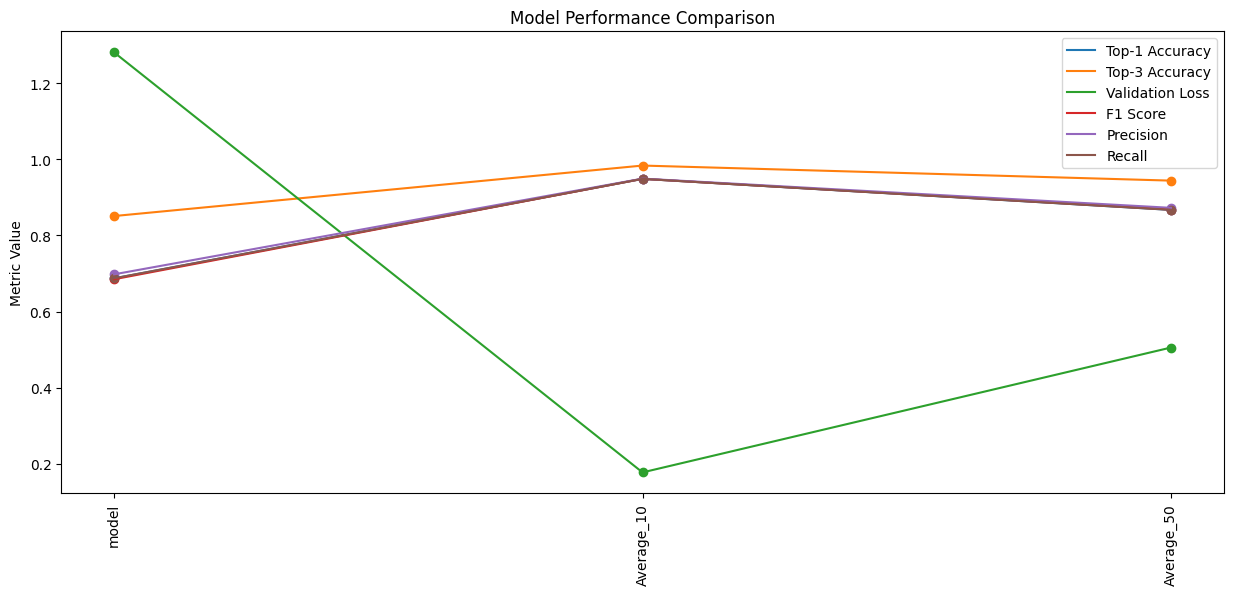

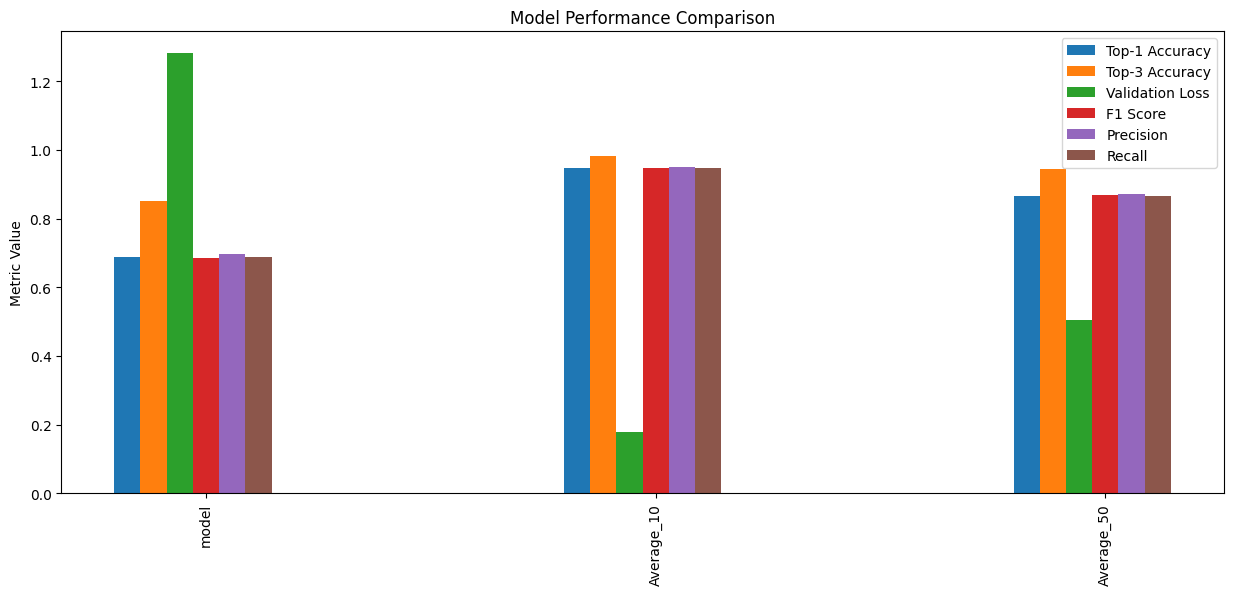

In [52]:
df = df.iloc[-3:, :]
fig, ax = plt.subplots(figsize=(15, 6))

x = np.arange(len(df))
width = 0.35

for i, metric in enumerate(df.columns[1:]):
    ax.plot(x, df[metric], label=metric)
    ax.scatter(x, df[metric], marker='o')

ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Metric Value')
plt.xticks(rotation=90)
plt.show()

# Bar plot
fig, ax = plt.subplots(figsize=(15, 6))

for i, metric in enumerate(df.columns[1:]):
    ax.bar(x - width/2 + i*width/len(df.columns[1:]), df[metric], width=width/len(df.columns[1:]), label=metric)

ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Metric Value')
plt.xticks(rotation=90)
plt.show()